In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as t
from torch.utils.data import DataLoader, Subset

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformations = t.Compose([t.ToTensor(), t.RandomHorizontalFlip(p=0.5), t.Normalize(0.5, 0.5)])

In [4]:
train_set = torchvision.datasets.FashionMNIST(root="fmnist", train=True, download=True, transform=transformations)
test_set = torchvision.datasets.FashionMNIST(root="fmnist", train=False, download=True, transform=transformations)

In [5]:
val_set, test_set = torch.utils.data.random_split(test_set, [0.6, 0.4])

In [6]:
label_categories = train_set.classes

In [7]:
print("Train: ", len(train_set))
print("Validation: ", len(val_set))
print("Test: ", len(test_set))

Train:  60000
Validation:  6000
Test:  4000


In [8]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=len(val_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

In [9]:
x, y = next(iter(train_loader))
print("Train: Image", x.size(), "and Length", len(train_loader), "Label", y.size())
x, y = next(iter(val_loader))
print("Val: Image", x.size(), "and Length", len(val_loader), "Label", y.size())
x, y = next(iter(test_loader))
print("Test: Image", x.size(), "and Length", len(test_loader), "Label", y.size())

Train: Image torch.Size([32, 1, 28, 28]) and Length 1875 Label torch.Size([32])
Val: Image torch.Size([6000, 1, 28, 28]) and Length 1 Label torch.Size([6000])
Test: Image torch.Size([4000, 1, 28, 28]) and Length 1 Label torch.Size([4000])


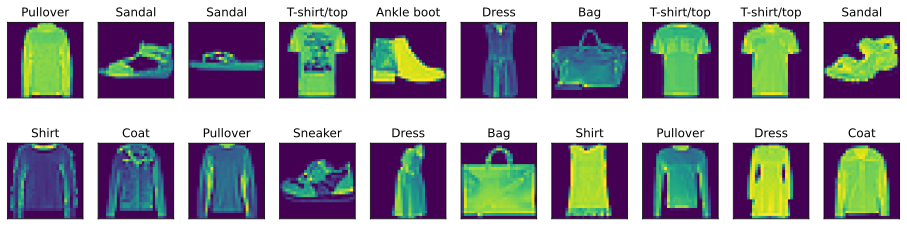

In [10]:
_, axis = plt.subplots(2, 10, figsize=(16, 4))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(x.size()[0])
    
    img = np.squeeze(x[pic, :, :, :])
    label = label_categories[y[pic]]
    
    ax.imshow(img)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [11]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
            self.b_norm1 = nn.BatchNorm2d(8)
            # (28 + 2*1 - 3)/1+1 = 28/2 = 14
            
            self.conv2 = nn.Conv2d(8, 14, 3, 1, 1)
            self.b_norm2 = nn.BatchNorm2d(14)
            # (14 + 2*1 - 3)/1 + 1 = 14/2 = 7
            
            self.conv3 = nn.Conv2d(14, 16, 2, 1)
            self.b_norm3 = nn.BatchNorm2d(16)
            # (7 + 2*0 - 2)/1 + 1 = 6/2 = 3
            
            self.fc1 = nn.Linear(3*3*16, 100)
            
            self.fc2 = nn.Linear(100, 50)
            
            self.out = nn.Linear(50, 10)
            
        def forward(self, x):
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            x = self.conv3(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm3(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            
            x = self.out(x)
            x = f.relu(x)
            
            return x
        
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
    
    return cnn, loss_fun, optimizer

In [12]:
summary(model()[0].to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 14, 14]              16
            Conv2d-3           [-1, 14, 14, 14]           1,022
       BatchNorm2d-4             [-1, 14, 7, 7]              28
            Conv2d-5             [-1, 16, 6, 6]             912
       BatchNorm2d-6             [-1, 16, 3, 3]              32
            Linear-7                  [-1, 100]          14,500
            Linear-8                   [-1, 50]           5,050
            Linear-9                   [-1, 10]             510
Total params: 22,150
Trainable params: 22,150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.08
Estimated Total Size (MB): 0.18
---------------------------------------------

In [13]:
x, y = next(iter(test_loader))

print("Shape:", x.size())

cnn = model()[0]

y_hat = cnn(x)

print(y_hat.shape)

Shape: torch.Size([4000, 1, 28, 28])
torch.Size([4000, 10])


In [14]:
def train_model():
    
    num_epochs = 10

    cnn, loss_fun, optimizer = model()
    cnn.to(device)
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
        
        cnn.train()
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            y_hat = cnn(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            y = y.cpu()
            y_hat = y_hat.cpu()
            
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        cnn.eval()
        x, y = next(iter(val_loader))
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
        
        y = y.cpu()
        y_hat = y_hat.cpu()
        
        val_loss.append(loss.item())
        val_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        
    return train_acc, train_loss, val_loss, val_acc, cnn, loss_fun

In [15]:
train_acc, train_loss, val_loss, val_acc, cnn, loss_fun = train_model()

In [16]:
cnn.eval()

x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
    y_hat = cnn(x)
    loss = loss_fun(y_hat, y)

y_hat = y_hat.cpu()
y = y.cpu()

test_loss = loss.item()
test_acc = 100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

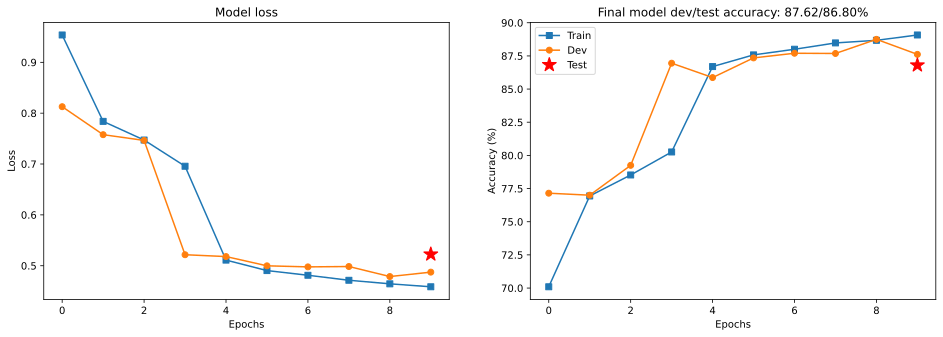

In [17]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-',label='Train')
ax[0].plot(val_loss, 'o-', label='Dev')
ax[0].plot(len(val_loss) - 1, test_loss, 'r*', markersize=15, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(val_acc, 'o-', label='Dev')
ax[1].plot(len(val_acc) - 1, test_acc, 'r*', markersize=15, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {val_acc[-1]:.2f}/{test_acc:.2f}%')
ax[1].legend();

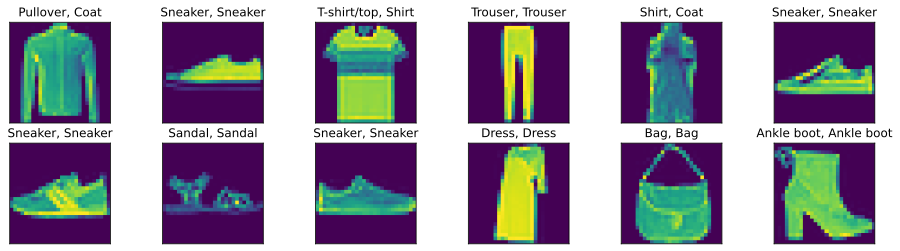

In [18]:
x, y = next(iter(test_loader))
cnn.to(device="cpu")
y_hat = cnn(x)

_, axis = plt.subplots(2, 6, figsize=(16, 4))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(x.size()[0])

    img = np.squeeze(x[pic, :, :, :])
    label_real = label_categories[y[pic]]
    label = torch.argmax(y_hat, axis=1)[pic]
    label_predict = label_categories[label]

    ax.imshow(img)
    ax.set_title(f"{label_real}, {label_predict}", )
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()